In [1]:
import os,sys
from dateutil.parser import parse
import numpy as np
from datetime import datetime
import time
from collections import Counter

sys.path.append("/Users/maithoma/work/python/")
from tm_python_lib import * 
from fitting_tools import *
from adaptive_kernel_tom import adaptive_kernel_quantile_pdf_tom

%matplotlib inline

In [2]:
fig_width_pt = 420.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0 / 72.27  # Convert pt to inch
golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Aesthetic ratio
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width  # *golden_mean      # height in inches
fig_size = [fig_width, fig_height]


params = {'backend': 'ps',
          'axes.labelsize': 25,
          'text.fontsize': 32,
          'legend.fontsize': 16,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'text.usetex': False,
          'figure.figsize': fig_size}
pl.rcParams.update(params)

In [3]:
def plotFit(loss,xmin=1,label=""):
    
    pl.close("all")
    pl.figure(1,(25,9))
    
    index,mu,error,llh,points = vary_threshold(loss,xmin=0.05,index=100,type='cont')

    pl.subplot(131)
    pl.semilogx(index,mu)
    pl.semilogx(index,mu + error)
    pl.semilogx(index,mu - error)
    pl.xlabel("threshold")
    pl.ylabel("exponent mu")

    pl.subplot(132)
    pl.semilogx(index,llh)
    pl.xlabel("threshold")
    pl.ylabel("Loglihelihood")

    pl.subplot(133)
    #xmin = index[np.argmax(llh)]
    mu,confidence,n = pwlaw_fit_cont(loss,xmin)
    
    print "nEvents: %.2f, %.2f , %.2f"%(len(loss),len(loss[loss<xmin]),len(loss[loss>=xmin]))
    print "sumLoss: %.2f, %.2f , %.2f"%(sum(loss),sum(loss[loss<xmin]),sum(loss[loss>=xmin]))
    print "min max: %.2f, %.2f"%(min(loss),max(loss))
    whatever = bootstrapping(loss,xmin,confint=.01,plot=True)
    print "fit: %s (p-value = %s, std.err = %.2f)"%(mu,whatever[-1],confidence)
    
    pl.xlabel("Loss")
    pl.ylabel("Rank Ordering")
    pl.title(label)
    
    
def bootstrapping(data,xmin,confint=.05,numiter = -1,plot=False,plotconfint=False):
    '''Bootstrapping power law distribution'''
    data = np.array(data) # make sure the input is an array
    sample = data[data >= xmin]
    mu,confidence,nPoints = pwlaw_fit_cont(sample,xmin) #fit original power law
        
    f = 1/(sample/float(xmin))**mu 
    ksInit = kstest(sample,f)
    #print ksInit
    
    if nPoints==0:
        print "no value larger than %s"%xmin
        return
    
    if numiter == -1:
        numiter = round(1./4*(confint)**-2)
    
    m = np.zeros([numiter,nPoints])
    i = 0
    k = 0
    while i < numiter:
        q2 = pwlaw(len(sample),xmin,mu)[0]
        m[i]=np.sort(q2)
        ks = kstest(q2,f)
        
        if ks > ksInit:
            k += 1
        
        i+=1
                    
    pvalue = k/float(numiter)
    U=np.percentile(m,100-confint*100,0)
    L=np.percentile(m,confint,0)
    
    if plot:
        x,y = rankorder(data)
        yNorm = y/float(y[-1])
        yMin = yNorm[x <= xmin][0]
        
        pl.loglog(x,yNorm,'k.')
        
        xFit = np.logspace(np.log10(xmin),np.log10(max(sample)))
        yFit = yMin*1/(xFit/float(xmin))**mu 
        
        pl.loglog(xFit,yFit,'r-')
        
        if plotconfint:
            x,y = rankorder(L)
            yLowerNorm = y/float(y[-1])
            pl.loglog(x,yMin*yLowerNorm,'m')
            x,y = rankorder(U)
            yUpperNorm = y/float(y[-1])
            pl.loglog(x,yMin*yUpperNorm,'b')
    
    
    
    return m,L,U,pvalue

def kstest(sample1,sample2):
    return np.max(np.abs(sample1 - sample2))

In [86]:
def crossLagCorr(x,y,lagspan=35):

    rho = []
    L = range(-lagspan,lagspan)

    for l in L:
        if l==0:
            rho.append(S.spearmanr(x,y)[0])
        elif l < 0:
             rho.append(S.spearmanr(x[-l:],y[:l])[0])
        else:
            rho.append(S.spearmanr(x[:-l],y[l:])[0])

    return L,rho

In [4]:
rootdir = "/Users/maithoma/work/untrackedProjects/mingyi/"
datadir = rootdir + "data/"

Twitter
(1.2139493423773073, 0.21199957600127201, 89)


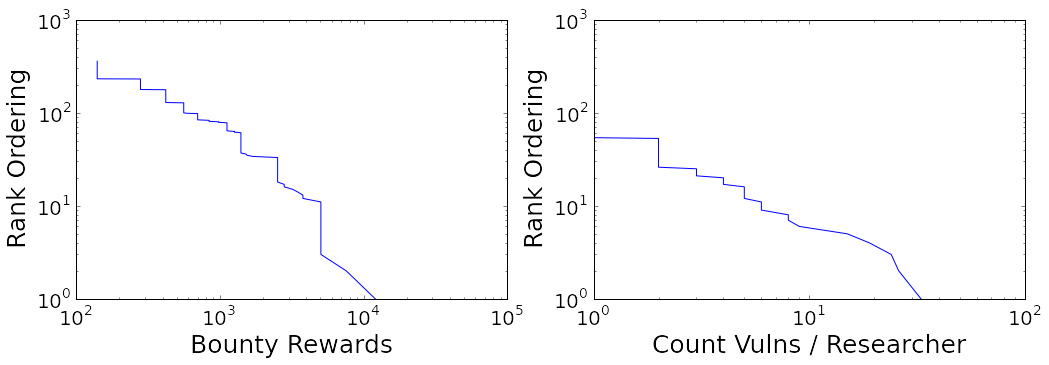

In [184]:
bprogram = ['Twitter','Coinbase','Slack','Square']
index = 0
print bprogram[index]
data = open(datadir + bprogram[index] + ".csv",'rb').read().split("\r")

date = []
reward = []
user = []

for i,line in enumerate(data):
    if i==0:
        continue
    line = line.split(",")
    date = np.append(date,time.mktime(parse(line[1]).timetuple()))
    reward = np.append(reward,float(line[2]))
    user = np.append(user,line[3])
    
date = (date - min(date) )/3600/24. + 1

pl.figure(1,(17,5))

pl.subplot(121)
x,y = rankorder(reward)
pl.loglog(x,y)
thresholds = [100,100,100,200]
pwlaw_fit_cont(x,thresholds[index])
pl.xlabel("Bounty Rewards")
pl.ylabel("Rank Ordering")

pl.subplot(122)
userCount = Counter(user)
x,y = rankorder(userCount.values())
pl.loglog(x,y)
x = x + np.random.rand(len(y)) - 0.5
print pwlaw_fit_cont(x,1)

pl.xlabel("Count Vulns / Researcher")
pl.ylabel("Rank Ordering")

CDF(X > x) = 1/x^mu = x^-mu
PDF(X=x) = 1/x^(mu+1) = x^-(mu +1)
alpha = mu +1

mu = 1.5 # coinbase

CDF (X > x = 5) = 1/5^1.5


In [185]:
1000*(1/10**1.5)

31.622776601683793

#### Arrival of new vulnerabilities

LinregressResult(slope=0.037286297577823146, intercept=0.73583664735993071, rvalue=0.1002501122731051, pvalue=0.75656691180238533, stderr=0.11702294004458212)


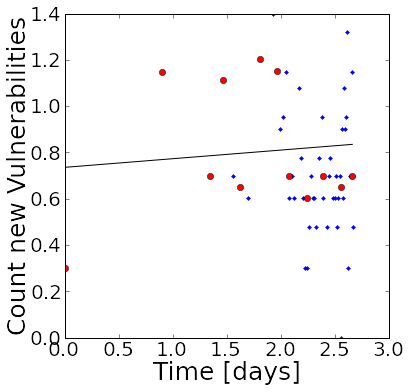

In [186]:
bins = np.arange(1,max(date)+1,7)
H = pl.histogram(date,bins = bins)
x = H[1][:-1]
y = H[0]

c = (y>0)*(x > 30.0)

lx = np.log10(x[c] - min(x[c])+1)
ly = np.log10(y[c])

B = binning(lx,ly,20)
c = (B[0] >= -1)*(B[0] < 3.0)*(B[1] > 0.1)

fit = S.linregress(B[0][c],B[1][c])
print fit

pl.plot(lx,ly,'b.')
pl.plot(B[0],B[1],'ro')
pl.plot(B[0][c],B[0][c]*fit[0]+fit[1],'k-')

pl.xlabel("Time [days]")
pl.ylabel("Count new Vulnerabilities")

#### Arrival of New Researchers

LinregressResult(slope=-0.404158586149515, intercept=1.2064453078524888, rvalue=-0.87262393296825946, pvalue=0.00021241767487512744, stderr=0.071530933372645586)


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


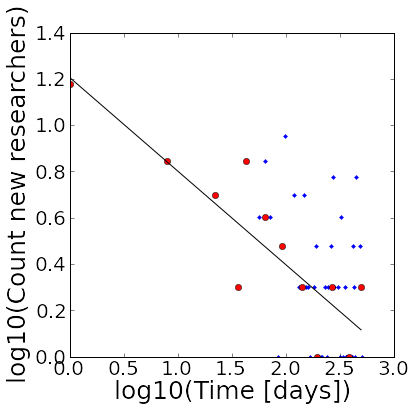

In [187]:
arrivals = []
uuser = []

for u in np.unique(user):
    index = np.argwhere(user==u)[0][0]
    arrivals = np.append(arrivals,index)
    uuser = np.append(uuser,u)
    #print u,date[arrivals[-1]]

o = np.argsort(arrivals)
uuser = uuser[o]
arrivals = arrivals[o]

binsize = 7
bins = np.arange(1,max(date)+1,binsize)
H = pl.histogram(date[list(arrivals)],bins = bins)
x = H[1][:-1]
y = H[0]

c = (y>0)*(x > 0)

lx = np.log10(x[c] - min(x[c])+1)
ly = np.log10(y[c])

B = binning(lx,ly,20)
c = (B[0] >= -1)*(B[0] < 3.0)#*(B[1] > .4)

fit = S.linregress(B[0][c],B[1][c])
print fit

pl.plot(lx,ly,'b.')
pl.plot(B[0],B[1],'ro')
pl.plot(B[0][c],B[0][c]*fit[0]+fit[1],'k-')

pl.xlabel("log10(Time [days])")
pl.ylabel("log10(Count new researchers)")

#### Researcher Arrival following rewards

51 47


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


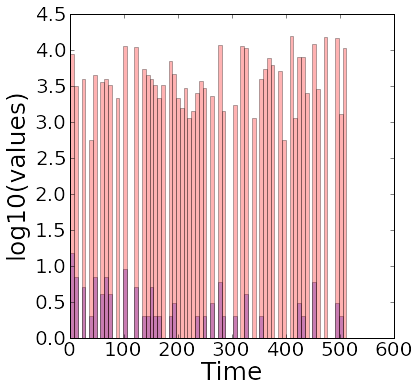

In [188]:
x = H[1][:-1]
y = H[0]

c = y > 0
x = x[c]
y = y[c]
ly = np.log10(y)

Hr = pl.histogram(date,weights=reward,bins=bins)
xr = Hr[1][:-1]
yr = Hr[0]

c = yr > 0
xr = xr[c]
yr = yr[c]
lyr = np.log10(yr)

Hra = pl.histogram(date[list(arrivals)],weights=reward[list(arrivals)],bins=bins)
xra = Hra[1][:-1]
yra = Hra[0]

c = yra > 0
xra = xra[c]
yra = yra[c]
lyra = np.log10(yra)

print len(lyr),len(lyra)

pl.bar(x,ly,binsize,color="blue",alpha=0.3)
pl.bar(xr,lyr,binsize,color = "red",alpha=0.3)
#pl.bar(xra,lyra,binsize,color = "purple",alpha=0.3)
pl.xlabel("Time")
pl.ylabel("log10(values)")

In [189]:
h = H[0] + np.random.rand(len(H[0])) - 0.5
hr = Hr[0] + np.random.rand(len(H[0])) - 0.5

print S.spearmanr(h,hr),len(h),len(hr)

SpearmanrResult(correlation=0.70061458718992964, pvalue=3.6856055040839574e-12) 74 74


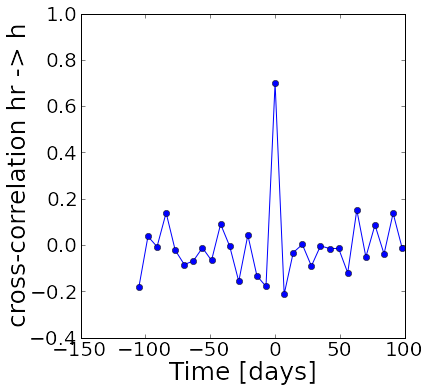

In [190]:
L,rho = crossLagCorr(hr[:],h[:],lagspan=15)
pl.plot(np.array(L)*binsize,rho,'o-')
pl.ylim(ymax=1)
pl.ylabel("cross-correlation hr -> h")
pl.xlabel("Time [days]")

#### Inter-time between 2 awards

In [191]:
test = []
for u in uuser:
    index = np.argwhere(user==u)
    df = np.diff(date[index].flatten())
    test = np.append(test,df)

10.9281481481 30.6054131257 51.3618638427 84.6650810185


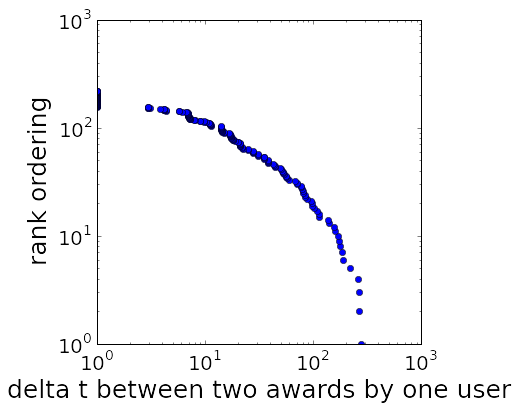

In [192]:
test[test < 1] = 1. 
x,y = rankorder(test)
pl.loglog(x,y,'o')
print np.median(test),np.mean(test),np.std(test),np.percentile(test,90)

pl.xlabel("delta t between two awards by one user")
pl.ylabel("rank ordering")

359 359
LinregressResult(slope=0.021686184969807929, intercept=2.4749626709201658, rvalue=0.33958133234524129, pvalue=3.8659760296789711e-11, stderr=0.0031790653496956457)
LinregressResult(slope=0.033098926111610742, intercept=2.2856456483077592, rvalue=0.78636612156817498, pvalue=1.1589370155236749e-06, stderr=0.0052004317798130719)
LinregressResult(slope=1.3164029643673456, intercept=2.4708817657594846, rvalue=0.93741045566352499, pvalue=2.266860775746369e-06, stderr=0.14744309216013557)


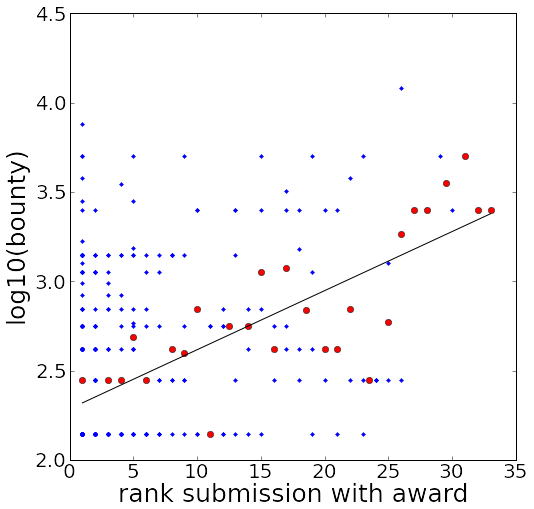

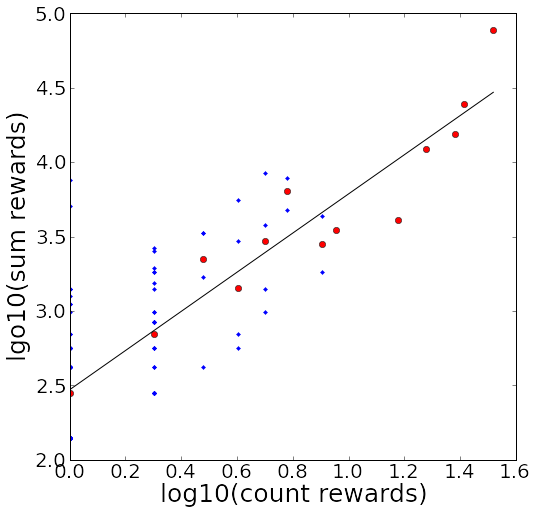

In [196]:
x = []
y = []

X = []
Y = []



for u in uuser:
    index = np.argwhere(user==u)
    x = np.append(x,len(reward[index].flatten()))
    y = np.append(y,np.sum(reward[index].flatten()))
    
    #print len(reward[index].flatten())
    Y = np.append(Y,reward[index].flatten())
    X = np.append(X,np.arange(1,len(reward[index].flatten())+1))

print len(X),len(Y)
    
pl.figure(1,(8,8))
c = (X > 0)*(Y > 0)
lX = np.log10(X[c])
lY = np.log10(Y[c])

B = binning(X[c],lY[c],30)
print S.linregress(X[c],lY[c])
fit = S.linregress(B[0],B[1])
print fit
pl.plot(X[c],lY[c],'.')
pl.plot(B[0],B[1],'ro')
pl.plot(B[0],B[0]*fit[0]+fit[1],'k-')
pl.xlabel("rank submission with award")
pl.ylabel("log10(bounty)")

pl.figure(2,(8,8))    
c = (x > 0)*(y > 0)
lx = np.log10(x[c])
ly = np.log10(y[c])

B = binning(lx,ly,30)
fit = S.linregress(B[0],B[1])
print fit
pl.plot(lx,ly,'.')
pl.plot(B[0],B[1],'ro')
pl.plot(B[0],B[0]*fit[0] + fit[1],'k-')
pl.xlabel("log10(count rewards)")
pl.ylabel("lgo10(sum rewards)")

### Remarks:
- there is clearly a learning effect for those who stay in the race.
- survivaly bias
- from this compute optimal strategy

### Jens' Ideas:
- two-sided market
- duplication : how competition goes given easyness of finding a vuln?